# Reana-SPL Data Analysis

This repository contains execution data and analysis for persistent variations of the [Reana-SPL](https://github.com/SPLMC/reana-spl) tool.

# SPL Analysis Approach

Reana-SPL performs a product-line reliability analysis on a variety of software-product-lines.

To leverage the commonality among different products in order to speed up analysis,
we use a [feature-family-based analysis](https://www.infosun.fim.uni-passau.de/publications/docs/LCA+17ist.pdf). Instead of enumerating products and analyzing
them one-by-one (product-based analysis), we analyze features in isolation
and exploit the commonality among products to get results for the entire
product space more efficiently.

We analyze the data of three approaches to handling the evolved models.
- Non-evolution-aware: The analysis tool does not do any
  special handling of evolved models (`reana`)
- Evolution-aware without reordering: The analysis tool handles evolved models
  by reusing ADDs generated in previous runs.
  ADDs are only automatically reordered in the first run (`reanaEord`).
- Evolution-aware with reordering: Same as the above, but ADDs are reordered
  automatically at each iteration (`reanaE`).

We expect the non-evolution-aware analysis to perform the worst, with
both evolution-aware approaches obtaining similar results.
There is a tradeoff to ADD reordering: while it is expensive, it obtains
smaller ADDs on which operations are easier to perform.

# Data 

The data used contains runtime information for different variations of the
[Reana-SPL](https://github.com/SPLMC/reana-spl) product line analysis tool.
Different approaches are implemented in different branches of the main repository.
The main difference in the implementations is in the handling of ADD persistence.
The non-evolution-aware does not save its generated ADDs nor does it read ADDs
from previous executions, as is done in the evolution-aware implementations.

We execute an evolution scenario on the initial models of 6 different product
lines (BSN, Email, IC, Lift, MP, TW).
Each evolution doubles the amount of products to be analyzed.
Each model is evolved in a fixed manner up to 22 times, so we have an
increase in the product space of up to \(2^21\)-fold


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools as iter
from tabulate import tabulate
from scipy.stats import *
from functools import reduce
from IPython.display import display, Markdown
from math import sqrt
from pprint import pprint

In [2]:
def cohens_d(s1, s2):
    assert(len(s1) == len(s2))
    N = len(s1)

    if N < 50:
        factor = ((N-3)/(N-2.25)) * sqrt((N-2)/N)
    else:
        factor = 1

    s = factor * sqrt((np.std(s1, ddof=1)**2 + np.std(s2, ddof=1)**2) / 2)
    cohens_d = (np.mean(s1) - np.mean(s2)) / s
    return cohens_d

def cliffs_delta_from_mann_whitney(u, m, n):
    return 2*u / (m*n) - 1


# Reading Data

In [3]:
def out_to_csv(in_filename, out_filename):
    data = []
    i = -1
    with open(in_filename) as in_f:
        lines = in_f.readlines()
    for line in lines:
        if not isNumber(line):
            i += 1
            data.append([])
        else:
            data[i].append(float(line))
    with open(out_filename, 'w') as out_f:
        for i in range(len(data)):
            for j in range(len(data[i])):
                if j == len(data[i])-1:
                    out_f.write("{}\n".format(data[i][j]))
                else:
                    out_f.write("{},".format(data[i][j]))
        
    
def isNumber(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def concat(lists):
    return list(iter.chain.from_iterable(lists))

In [4]:
def _read_data(spl, filenames, labels, factor=1.0, trim_rows=True, trim_columns=False):
    dfs = []
    for filename in filenames:
        df = pd.read_csv(filename, header=None).transpose()
        dfs.append(df)

    if trim_rows:
        # delete extra rows (to match sample sizes)
        n = min([df.shape[0] for df in dfs])
        for df in dfs:
            if df.shape[0] > n:
                rows = list(range(n, df.shape[0]))
                df = df.drop(rows, inplace=True) 

    if trim_columns:
        # delete extra columns (to match number of evolutions)
        m = min([df.shape[1] for df in dfs])
        for df in dfs:
            if df.shape[1] > m:
                cols = list(range(m, df.shape[1]))
                df = df.drop(cols, axis=1, inplace=True)
        
    df = pd.concat(dfs, keys=labels)
    df *= factor
    
    return df, n

def read_data(spl, filenames, labels, factor=1.0, trim_rows=True, trim_columns=False):
    df, n = _read_data(spl, filenames, labels, factor=factor, trim_rows=trim_rows, trim_columns=trim_columns)
    df['Label'] = np.repeat(labels, np.repeat([n], len(labels)), axis=0)
    return df

# Plotting Graphs

In [5]:
def make_line_graph(df, spl, labels, title=None, yscale='linear', xlabel='x', ylabel='y', filename=None):

    means = []
    stds = []

    for label in labels:
        dfl = df.loc[label]
        means.append(np.mean(dfl))
        stds.append(np.std(dfl))
    
    df_mean = pd.concat(means, keys=labels)
    df_std = pd.concat(stds, keys=labels)
    
    plt.figure(figsize=(12,5)) # TODO: is this OK?
    
    axs = []

    for i in range(len(labels)):
        label = labels[i]
        if i == 0:
            ax = df_mean[label].plot(grid=True, yerr=df_std[label], label=label)
        else:
            ax = df_mean[label].plot(grid=True, secondary_y=False, yerr=df_std[label], label=label)

        axs.append(ax)

    xticks = np.arange(0, df_mean[labels[0]].shape[0], 1)

    for ax in axs:
        ax.set_xticks(xticks)
    
    # plt.legend(h1+h2, l1+l2, loc=2)
    plt.legend()
    plt.yscale(yscale)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if title is None:
        plt.title(spl)
    else:
        plt.title(title)
    if filename is not None:
        plt.savefig(filename)
        
    plt.show()

In [6]:
def make_box_plot(df, spl, title=None, xlabel='', ylabel='', filename=None):
    means = np.mean(df)
    stdevs = np.std(df)
    fig, ax_new = plt.subplots(5, 5, sharex=False, sharey=False, figsize=(20,20))
    
    # these magics work for 5 by 5 plots, which is appropriate for our current data dimensions
    i = 4
    j = 4
    while i * 5 + j + 1 > len(means):
        fig.delaxes(ax_new[i, j])
        if j == 0:
            j = 4
            i -= 1
        else:
            j -= 1

    bp = df.boxplot(by="Label",ax=ax_new.flatten()[:len(means)], figsize=(6,8))

    for i in range(len(means)):
        ax_new.flatten()[i].autoscale()
        ax_new.flatten()[i].set_xlabel(xlabel)
        ax_new.flatten()[i].set_ylabel(ylabel)
    
    if title is None:
        title = spl

    fig.suptitle(title)
    
    if filename is not None:
        plt.savefig(filename)

    plt.show()

In [7]:
def get_means_df(df, labels):
    dfs = [np.mean(df.loc[label]) for label in labels]
    return pd.concat(dfs, keys=labels)

# Statistical Testing

In [8]:
def is_normally_distributed(samples, significance=0.01):
    x, p = normaltest(samples)
    return p >= significance

def compare_samples(s1, s2, significance=0.01):
    if s1.equals(s2):
        d = cohens_d(s1, s2)
        return {'result': 'eq', 'method': 'all-equal', 'd': d}
    if (is_normally_distributed(s1, significance=significance)
        and is_normally_distributed(s2, significance=significance)):
        # both normally distributed
        v1, p1 = bartlett(s1, s2)                                 # test variances
        equal_var= p1 >= significance
        
        v2, p2 = ttest_ind(s1, s2, equal_var=equal_var)  # equal variances is assumed unless stated otherwise
        
        method = 'T-test' if equal_var else 'Welch'      # from ttest_ind's documentation
        eq = p2 >= significance
        diff = np.mean(s1) - np.mean(s2)
        d = cohens_d(s1, s2)
        r = "eq" if eq else 'gt' if diff > 0 else 'lt'
        
        return {'result': r, 'method': method, 'p1': p1, 'v1': v1, 'p2': p2, 'v2': v2, 'd': d}
    else:
        # not both normally distributed
        u, p = mannwhitneyu(s1, s2, use_continuity=False)
        eq = p >= significance
        diff = np.mean(s1) - np.mean(s2)
        d = cliffs_delta_from_mann_whitney(u, len(s1), len(s2))
        r = 'eq' if eq else 'gt' if diff > 0 else 'lt'
        d = cohens_d(s1, s2) # not sure if can use d test when not normally distributed
        return {'result': r, 'method': 'Mann-Whitney', 'u': u, 'p2': p, 'd': d}

In [9]:
def test_all_evolutions_pairs(df, labels):
    pairs = list(iter.combinations(labels, 2))
    return [(t1, t2, test_all_evolutions(df, t1, t2)) for (t1, t2) in pairs]

def test_all_evolutions(df, t1, t2):
    n = get_num_evolutions(df)
    return [test(df, i, t1, t2) for i in range(n)]

def test(df, i, t1, t2):
    s1 = get_evolution_samples(df, i, label=t1)
    s2 = get_evolution_samples(df, i, label=t2)
    if s1 is None or s2 is None:
        # one of the samples contains NaN
        return None
    else:
        return compare_samples(s1, s2)

def print_test_results(t1, t2, comparison, verbose=False):
    if verbose:
        print('{}\t{}'.format(i, comparison))
    else:
        if comparison is None:
            print('No samples')
        elif result['result'] == 'eq':
            print('{} == {}'.format(t1, t2))
        elif result['result'] == 'lt':
            print('{} > {}'.format(t1, t2))
        elif result['result'] == 'gt':
            print('{} < {}'.format(t1, t2))

def get_num_evolutions(df):
    label = df['Label'][0]
    return df.loc[label].shape[1] - 1  # exclude type column

def get_evolution_samples(df, n, label):
    s = df.iloc[:][n].loc[label]
    if s.isnull().any():  # check if any sample is NaN
        return None
    else:
        return s

In [10]:
def test_min(ordering):
    '''
    ordering has format
    [(x, y, compare(x,y)), (x, z, compare(x,z)), (y, z, compare(y,z))]
    returns the smallest element or None if there is no such element.
    
    Example: [(x, y, 'eq'), (x, z, 'gt'), (y, z, 'gt')] => z
    '''
    candidates = get_valid_labels(ordering)
    for (t1, t2, c) in ordering:
        if c == 'eq':
            if t1 in candidates: candidates.remove(t1)
            if t2 in candidates: candidates.remove(t2)
        elif c == 'lt':
            if t2 in candidates: candidates.remove(t2)
        elif c == 'gt':
            if t1 in candidates: candidates.remove(t1)
    if len(candidates) == 1:
        return candidates[0]
    else:
        return None
        
def get_orderings(tests):
    orderings = (
        list(
            zip(*[
                [
                    (t1, t2, t['result'] if t else None, t['d'] if t else None) for t in ts
                ]
                for (t1, t2, ts) in tests]
            )
        )
    )
    return orderings

def get_valid_labels(ordering):
    elements = []
    for element in ordering:
        if element[2] is not None:
            elements.append(element[0:2])
    return list(set(concat(elements)))


In [26]:
# This cell is tasked with producing tables comparing the results of two labels,
# including the hypothesis test, as well as the effect size.

def process_effect_size(d):
    d = abs(d)
    points = [('Small', 0.2), ('Medium', 0.5), ('Large', 0.8)]
    dists = [(label, abs(d - x)) for (label, x) in points]
    dists.sort(key=lambda item: item[1])
    return dists[0][0]

def get_test_comparison_df(df, l1, l2, suffix=None):
    tests = test_all_evolutions(df, l1, l2)
    comparisons = [test['result'] for test in tests if test is not None]

    avg1 = np.mean(df.loc[l1])
    avg2 = np.mean(df.loc[l2])

    effect_size = [process_effect_size(test['d']) for test in tests if test is not None]
    # hypothesis: assume that both labels obtain the same result
    hypothesis_results = ['Confirm' if x == 'eq' else 'Reject' for x in comparisons]

    label1 = l1 if suffix is None else '{} {}'.format(l1, suffix)
    label2 = l2 if suffix is None else '{} {}'.format(l2, suffix)

    data = {label1: avg1, label2: avg2 , 'H0': hypothesis_results, 'Effect Size': effect_size}
    return pd.DataFrame(data=data)

def get_test_comparison_dfs(model, df1, df2, l1, l2, suffix1=None, suffix2=None):
    test_df1 = get_test_comparison_df(df1, l1, l2, suffix=suffix1)
    test_df2 = get_test_comparison_df(df2, l1, l2, suffix=suffix2)

    n1 = get_num_evolutions(df1)
    n2 = get_num_evolutions(df2)

    if (n1 != n2):
        print("Warning: number of evolutions in df1 and df2 do not match")

    model_labels = ['{} {}'.format(model, i) for i in range(n1)]
    model_df = pd.DataFrame({'Model': model_labels})

    return pd.concat([model_df, test_df1, test_df2], axis=1)

In [27]:
def get_table(df, labels, title=None, items_per_row=0, bolded=None):
    # generating lines and headers/separators
    lines = {}
    mdf = get_means_df(df, labels)
    n = get_num_evolutions(df)
    r = ((n // items_per_row) + 1) * items_per_row
    for label in labels:
        lines[label] = get_lines_for_label(mdf, label, n, items_per_row, bolded)

    header = format_row([' Type '] + [' ' + str(i) + ' ' for i in range(items_per_row)])
    first_separator = format_row(['---' for i in range(items_per_row + 1)])
    last_separator  = format_row(['---' for i in range(items_per_row + 1)])
    separator = (
        lambda k :
            format_row([' --- '] + [' ' + (str(i) if i < n else '---') + ' ' for i in range(items_per_row * k, items_per_row * (k + 1) )])
    )
    separators = [first_separator] + [separator(i) for i in range(1, r // items_per_row)] + [last_separator]    

    # writing to buffer
    buffer = ''
    if title:
        buffer += '| {} |\n'.format(str(title))
    buffer += header + '\n'

    flag = True
    i = 0
    while flag:
        buffer += separators[i] + '\n'
        for label in labels:
            if not lines[label]:
                flag = False
                break
            line = lines[label].pop(0)
            buffer += line + '\n'
        i += 1
    return buffer
    
def get_lines_for_label(mdf, label, n, m=0, mins=None):
    '''
    mdf: dataframe containing averages
    label: label for which table lines are generated
    n: number of total elements for each label in mdf
    m: number of elements per row
    mins: label to be bolded for each item
    '''
    lines = []
    r = ((n // m) + 1) * m
    s = '| {} '.format(label)
    for i in range(r):
        if i < n:
            x = mdf.loc[label].iloc[i]
            value = '--' if isnan(x) else '{x:.2f}'.format(x=x)
            if i < n and mins is not None and mins[i] == label:
                s += '| **{}** '.format(value)
            else:
                s += '| {} '.format(value)
        else:
            value = '--'
            s += '| {} '.format(value)

        if m != 0 and i != 0 and i != (r-1) and (i+1) % m == 0:
            lines.append(s + '|')
            s = '| {} '.format(label)

    lines.append(s + '|')
    return lines

def isnan(x):
    return x is float('nan') or x == 'nan' or x == np.nan or np.isnan(x)

def format_row(items):
    return reduce(
        lambda a, b: a + b,
        ['|{}'.format(x) for x in items] + ['|']
    )

# Running and Displaying Results

In [28]:
# This cells converts .out files to .csv
spls = ['BSN', 'Email', 'IC', 'Lift', 'MP', 'TW']
labels = ['Reana', 'ReanaE', 'ReanaEord']

rt_data = concat([['running_time/totalTime{}{}'.format(spl, label) for spl in spls] for label in labels])
mem_data = concat([['memory_usage/totalMemory{}{}'.format(spl, label) for spl in spls] for label in labels])

for filename in rt_data:
    out_to_csv('data/{}.out'.format(filename), 'csv/{}.csv'.format(filename))

for filename in mem_data:
        out_to_csv('data/{}.out'.format(filename), 'csv/{}.csv'.format(filename))

In [29]:
def plot_spl(spl):
    def process(df, labels, title, header=None, xlabel='Evolution', ylabel='', yscale='log', factor=1.0, table_suffix='', table_description=None):
        if header:
            display(Markdown('## {}'.format(header)))
        make_line_graph(df, spl, labels, title=title, xlabel=xlabel, ylabel=ylabel, yscale='log')   

        test_results = test_all_evolutions_pairs(df, labels)

        make_box_plot(df, spl, title=title)

        orderings = get_orderings(test_results)

        # mins = [test_min(ordering) for ordering in orderings]
        mins = [test_min([(t1, t2, c) for (t1, t2, c, _) in ordering]) for ordering in orderings]

        n = get_num_evolutions(df)

        items_per_row = min(n, 10)

        if table_description:
            display(Markdown(table_description))
        table = get_table(df, labels, title=None, items_per_row=items_per_row, bolded=mins)

        display(Markdown(table))

        with open('tables/{}{}.md'.format(spl, table_suffix), 'w') as f:
            f.write(table)


    labels = ['Reana', 'ReanaE', 'ReanaEOrd']

    display(Markdown('# {}'.format(spl)))
    rt_filenames = ['csv/running_time/totalTime{}{}.csv'.format(spl, label) for label in labels]
    factor = 1e-3
    rt_df = read_data(spl, rt_filenames, labels, factor=factor)
    process(rt_df, labels, '{}: Running Time'.format(spl), header='Running Time',
        ylabel='Running Time (s)', factor=1.0/1000.0, table_suffix='rt',
        table_description="Average running time (s) (statistically smallest value in bold)")

    mem_filenames = ['csv/memory_usage/totalMemory{}{}.csv'.format(spl, label) for label in labels]
    mem_df = read_data(spl, mem_filenames, labels)
    process(mem_df, labels, '{}: Memory Usage'.format(spl), header='Memory Usage',
        ylabel='Memory Usage (MB)', table_suffix='mem',
        table_description="Average memory usage (MB) (statistically smallest value in bold)")

    l1 = labels[0]
    l2 = labels[1]

    rt_df = read_data(spl, rt_filenames, labels, factor=factor, trim_columns=True) 
    mem_df = read_data(spl, mem_filenames, labels, trim_columns=True)
    test_df = get_test_comparison_dfs(spl, rt_df, mem_df, l1, l2, suffix1='Runtime (s)', suffix2='Memory Usage (MB)')
    display(test_df)

# BSN

## Running Time

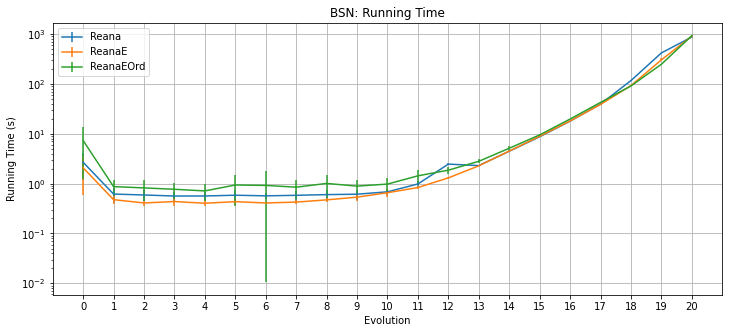

/Users/breno/Library/Python/3.8/lib/python/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/breno/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


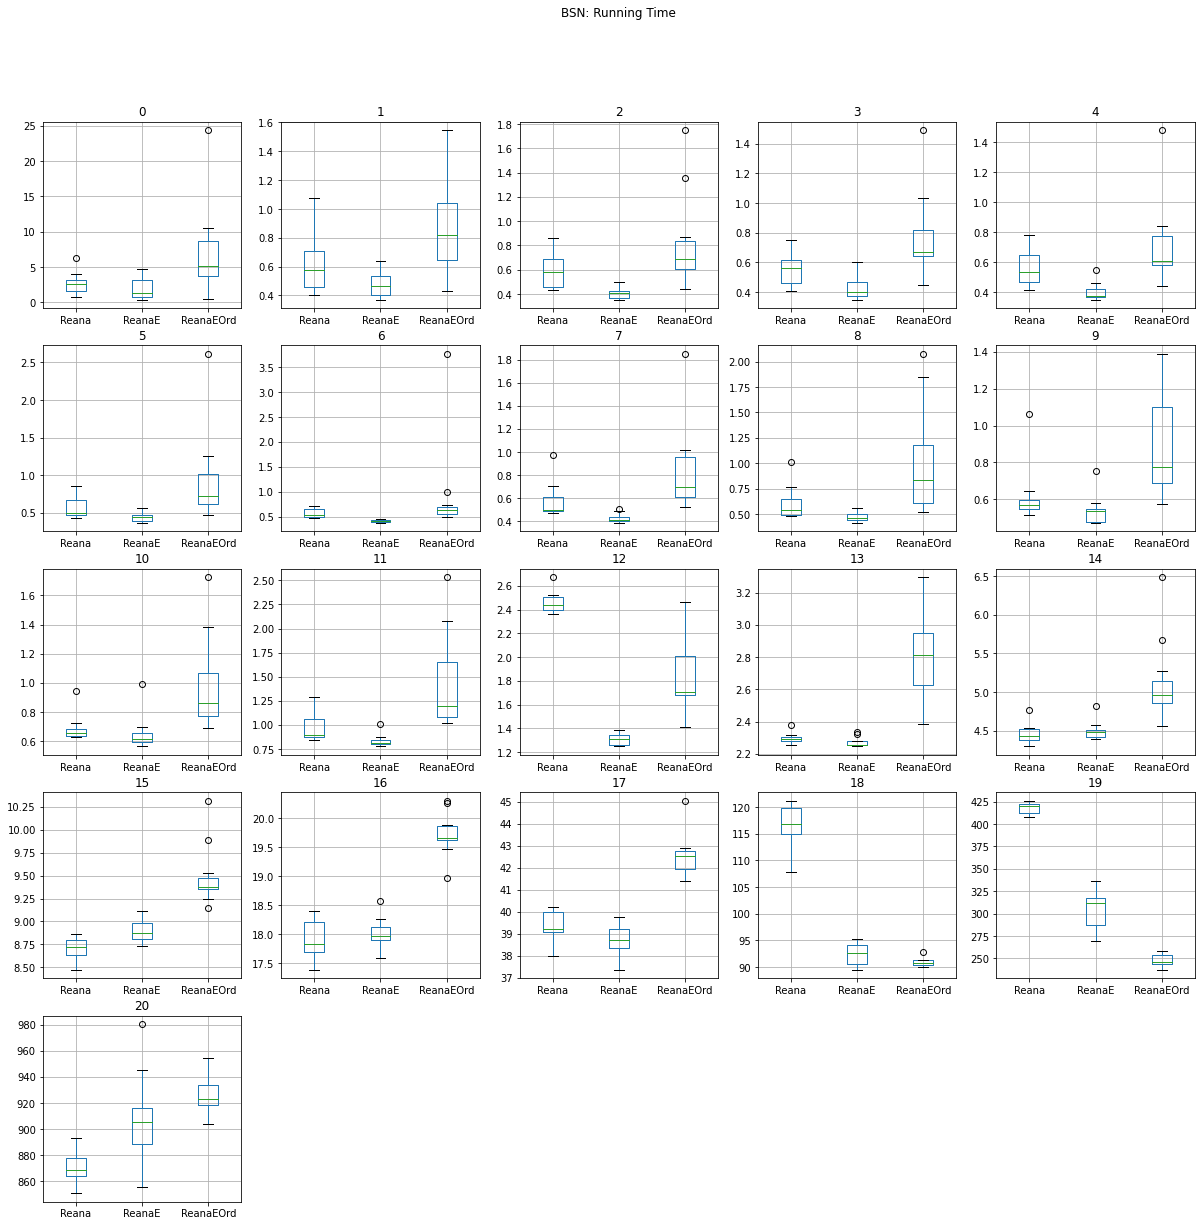

Average running time (s) (statistically smallest value in bold)

| Type | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 2.68 | 0.62 | 0.59 | 0.56 | 0.57 | 0.59 | 0.57 | 0.58 | 0.60 | 0.61 |
| ReanaE | 2.08 | 0.48 | **0.41** | **0.44** | **0.40** | 0.43 | **0.41** | **0.43** | **0.47** | 0.54 |
| ReanaEOrd | 7.31 | 0.87 | 0.82 | 0.77 | 0.71 | 0.94 | 0.92 | 0.85 | 1.01 | 0.89 |
| --- | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 |
| Reana | 0.68 | 0.98 | 2.46 | 2.30 | 4.46 | **8.70** | 17.91 | 39.32 | 116.67 | 418.06 |
| ReanaE | 0.66 | **0.83** | **1.30** | 2.27 | 4.49 | 8.89 | 18.02 | 38.74 | 92.39 | 302.94 |
| ReanaEOrd | 0.98 | 1.43 | 1.86 | 2.80 | 5.12 | 9.49 | 19.73 | 42.52 | 90.89 | **247.68** |
| --- | 20 | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Reana | **871.06** | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | 906.22 | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaEOrd | 925.86 | -- | -- | -- | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


## Memory Usage

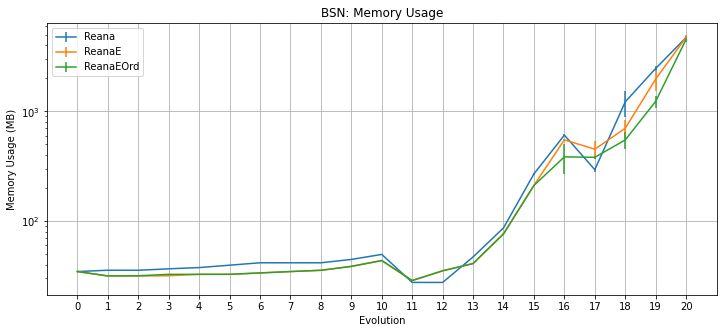

/Users/breno/Library/Python/3.8/lib/python/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
<ipython-input-2-f2f29a278346>:11: RuntimeWarning: divide by zero encountered in double_scalars
  cohens_d = (np.mean(s1) - np.mean(s2)) / s
<ipython-input-2-f2f29a278346>:11: RuntimeWarning: invalid value encountered in double_scalars
  cohens_d = (np.mean(s1) - np.mean(s2)) / s
/Users/breno/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


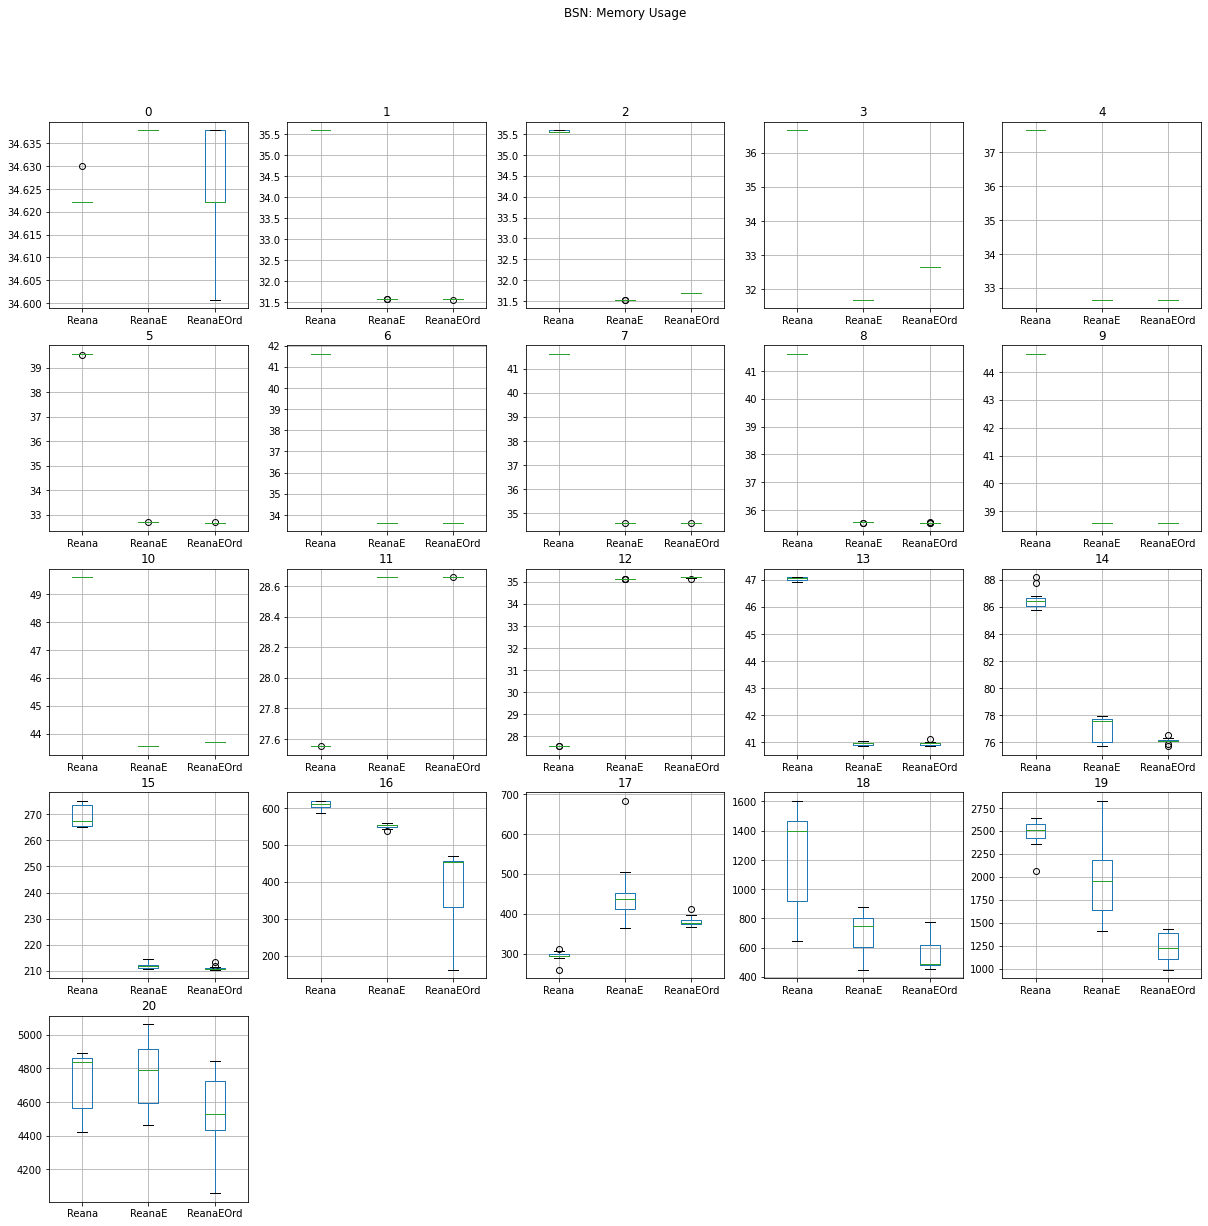

Average memory usage (MB) (statistically smallest value in bold)

| Type | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 34.62 | 35.59 | 35.56 | 36.66 | 37.64 | 39.57 | 41.62 | 41.62 | 41.62 | 44.66 |
| ReanaE | 34.64 | 31.57 | **31.54** | **31.70** | 32.66 | 32.68 | **33.62** | 34.61 | 35.56 | 38.58 |
| ReanaEOrd | 34.63 | **31.57** | 31.70 | 32.66 | 32.66 | **32.66** | 33.64 | 34.61 | **35.54** | 38.58 |
| --- | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 |
| Reana | 49.62 | **27.55** | **27.54** | 47.04 | 86.57 | 269.47 | 608.17 | **294.40** | 1224.18 | 2469.70 |
| ReanaE | **43.54** | 28.66 | 35.13 | 40.94 | 76.91 | 212.00 | 550.91 | 452.25 | 702.83 | 1974.24 |
| ReanaEOrd | 43.70 | 28.66 | 35.20 | 40.96 | 76.11 | 211.13 | **385.17** | 381.59 | **549.77** | **1236.79** |
| --- | 20 | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Reana | 4735.15 | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | 4759.33 | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaEOrd | 4557.51 | -- | -- | -- | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


/Users/breno/Library/Python/3.8/lib/python/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
<ipython-input-2-f2f29a278346>:11: RuntimeWarning: divide by zero encountered in double_scalars
  cohens_d = (np.mean(s1) - np.mean(s2)) / s


Model  Reana Runtime (s)  ReanaE Runtime (s)       H0 Effect Size  \
0    BSN 0           2.676273            2.076909  Confirm      Medium   
1    BSN 1           0.617364            0.476818  Confirm       Large   
2    BSN 2           0.591818            0.409636   Reject       Large   
3    BSN 3           0.563727            0.436909   Reject       Large   
4    BSN 4           0.565273            0.404273   Reject       Large   
5    BSN 5           0.585455            0.434545  Confirm       Large   
6    BSN 6           0.568636            0.409364   Reject       Large   
7    BSN 7           0.582818            0.426091   Reject       Large   
8    BSN 8           0.602000            0.472182   Reject       Large   
9    BSN 9           0.613364            0.535455  Confirm       Large   
10  BSN 10           0.684909            0.656455  Confirm       Small   
11  BSN 11           0.984000            0.834636   Reject       Large   
12  BSN 12           2.461364            1.303636   Reject       Large   
13  BSN 13           2.297636            2.272182  Confirm       Large   
14  BSN 14           4.462818            4.494727  Confirm       Small   
15  BSN 15           8.703909            8.891818   Reject       Large   
16  BSN 16          17.913636           18.022091  Confirm      Medium   
17  BSN 17          39.319455           38.741818  Confirm       Large   
18  BSN 18         116.674364           92.386727   Reject       Large   
19  BSN 19         418.057364          302.942909   Reject       Large   
20  BSN 20         871.061091          906.224182   Reject       Large   

    Reana Memory Usage (MB)  ReanaE Memory Usage (MB)       H0 Effect Size  
0                 34.622956                 34.637871   Reject       Large  
1                 35.590073                 31.568647   Reject       Large  
2                 35.563090                 31.537615   Reject       Large  
3                 36.657333                 31.695312   Reject       Small  
4                 37.638847                 32.657333   Reject       Small  
5                 39.571219                 32.679490   Reject       Large  
6                 41.617401                 33.623260   Reject       Small  
7                 41.617401                 34.606017   Reject       Large  
8                 41.617401                 35.561480   Reject       Large  
9                 44.657333                 38.577469   Reject       Small  
10                49.617401                 43.537537   Reject       Small  
11                27.553195                 28.658223   Reject       Large  
12                27.537626                 35.127487   Reject       Large  
13                47.036745                 40.942920   Reject       Large  
14                86.572386                 76.905229   Reject       Large  
15               269.471591                212.003084   Reject       Large  
16               608.169877                550.911399   Reject       Large  
17               294.398084                452.246697   Reject       Large  
18              1224.178578                702.830123   Reject       Large  
19              2469.696378               1974.241832   Reject       Large  
20              4735.150213               4759.332919  Confirm       Small

In [30]:
plot_spl('BSN')

# Email

## Running Time

/Users/breno/Library/Python/3.8/lib/python/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


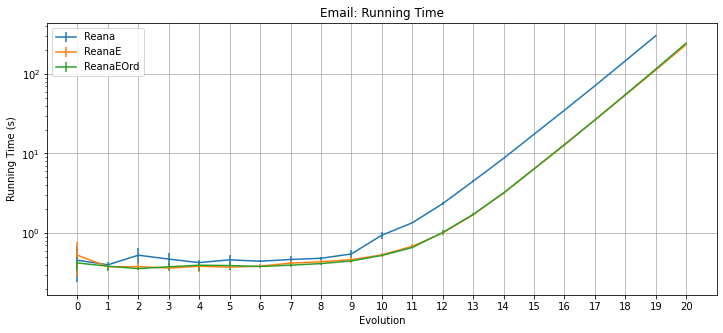

/Users/breno/Library/Python/3.8/lib/python/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/breno/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


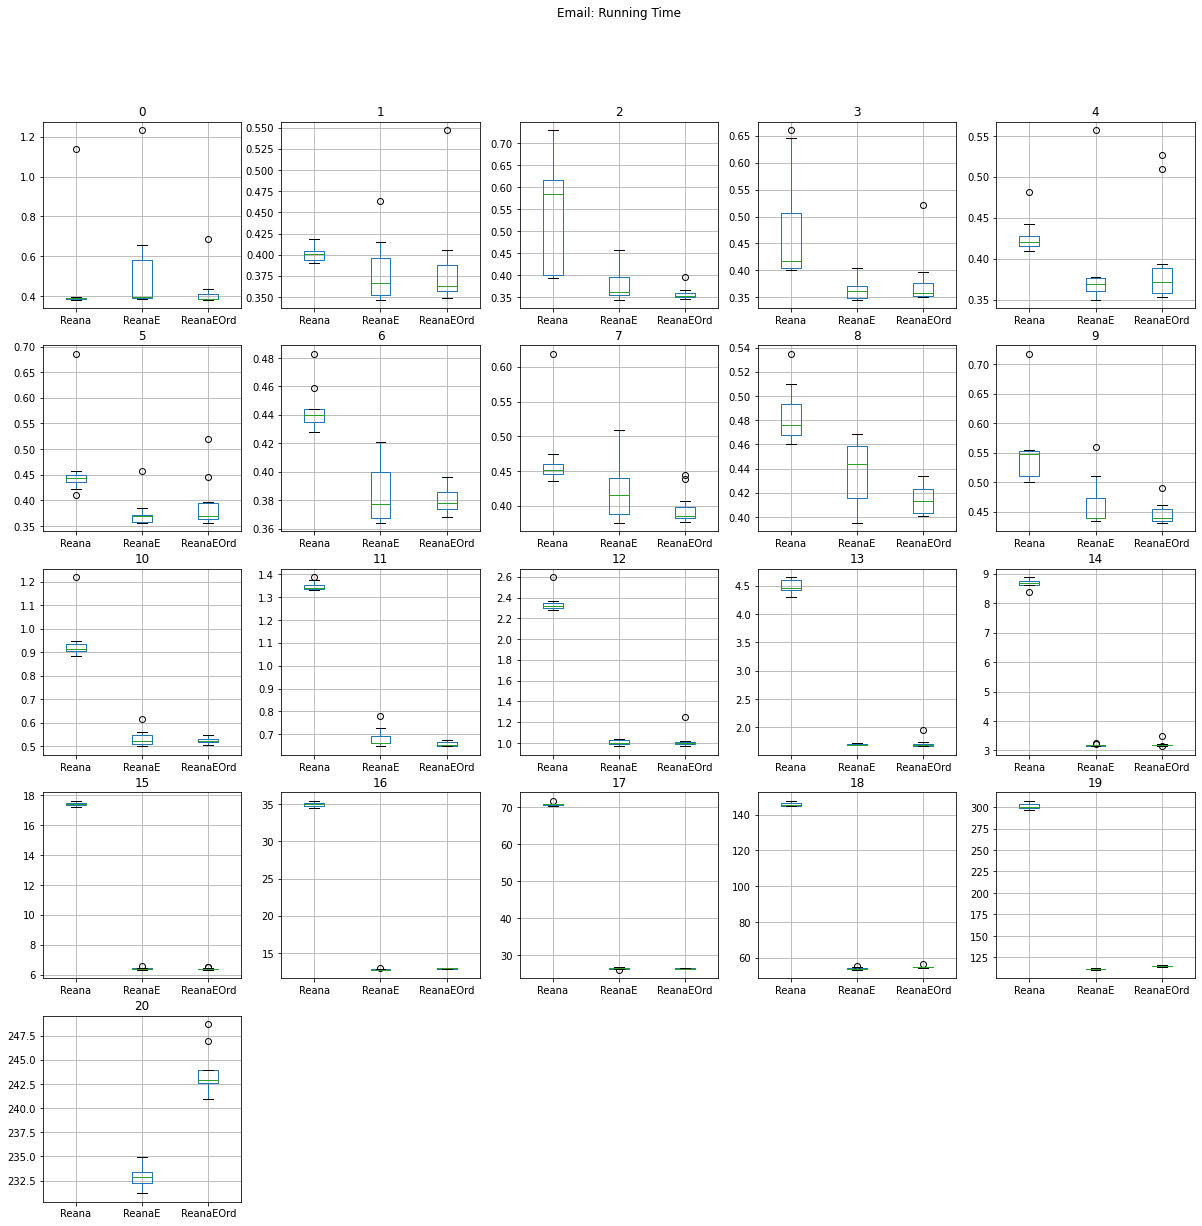

Average running time (s) (statistically smallest value in bold)

| Type | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 0.46 | 0.40 | 0.53 | 0.47 | 0.43 | 0.46 | 0.44 | 0.47 | 0.48 | 0.55 |
| ReanaE | 0.53 | 0.38 | 0.38 | 0.36 | 0.38 | 0.37 | 0.38 | 0.42 | 0.44 | 0.46 |
| ReanaEOrd | 0.42 | 0.38 | 0.36 | 0.38 | 0.40 | 0.39 | 0.38 | 0.40 | 0.41 | 0.45 |
| --- | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 |
| Reana | 0.94 | 1.35 | 2.35 | 4.49 | 8.69 | 17.44 | 34.97 | 70.78 | 145.80 | 301.25 |
| ReanaE | 0.53 | 0.68 | 1.00 | 1.70 | 3.17 | 6.41 | **12.79** | 26.46 | **54.06** | **111.61** |
| ReanaEOrd | 0.52 | 0.66 | 1.02 | 1.72 | 3.20 | 6.39 | 12.94 | 26.33 | 54.87 | 114.84 |
| --- | 20 | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Reana | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | **232.93** | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaEOrd | 243.80 | -- | -- | -- | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


## Memory Usage

/Users/breno/Library/Python/3.8/lib/python/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


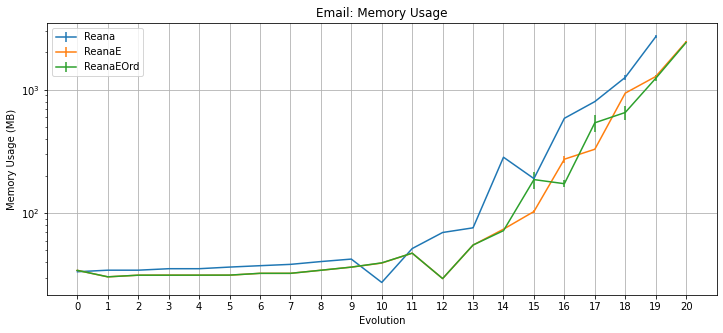

/Users/breno/Library/Python/3.8/lib/python/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
<ipython-input-2-f2f29a278346>:11: RuntimeWarning: divide by zero encountered in double_scalars
  cohens_d = (np.mean(s1) - np.mean(s2)) / s
<ipython-input-2-f2f29a278346>:11: RuntimeWarning: invalid value encountered in double_scalars
  cohens_d = (np.mean(s1) - np.mean(s2)) / s
/Users/breno/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


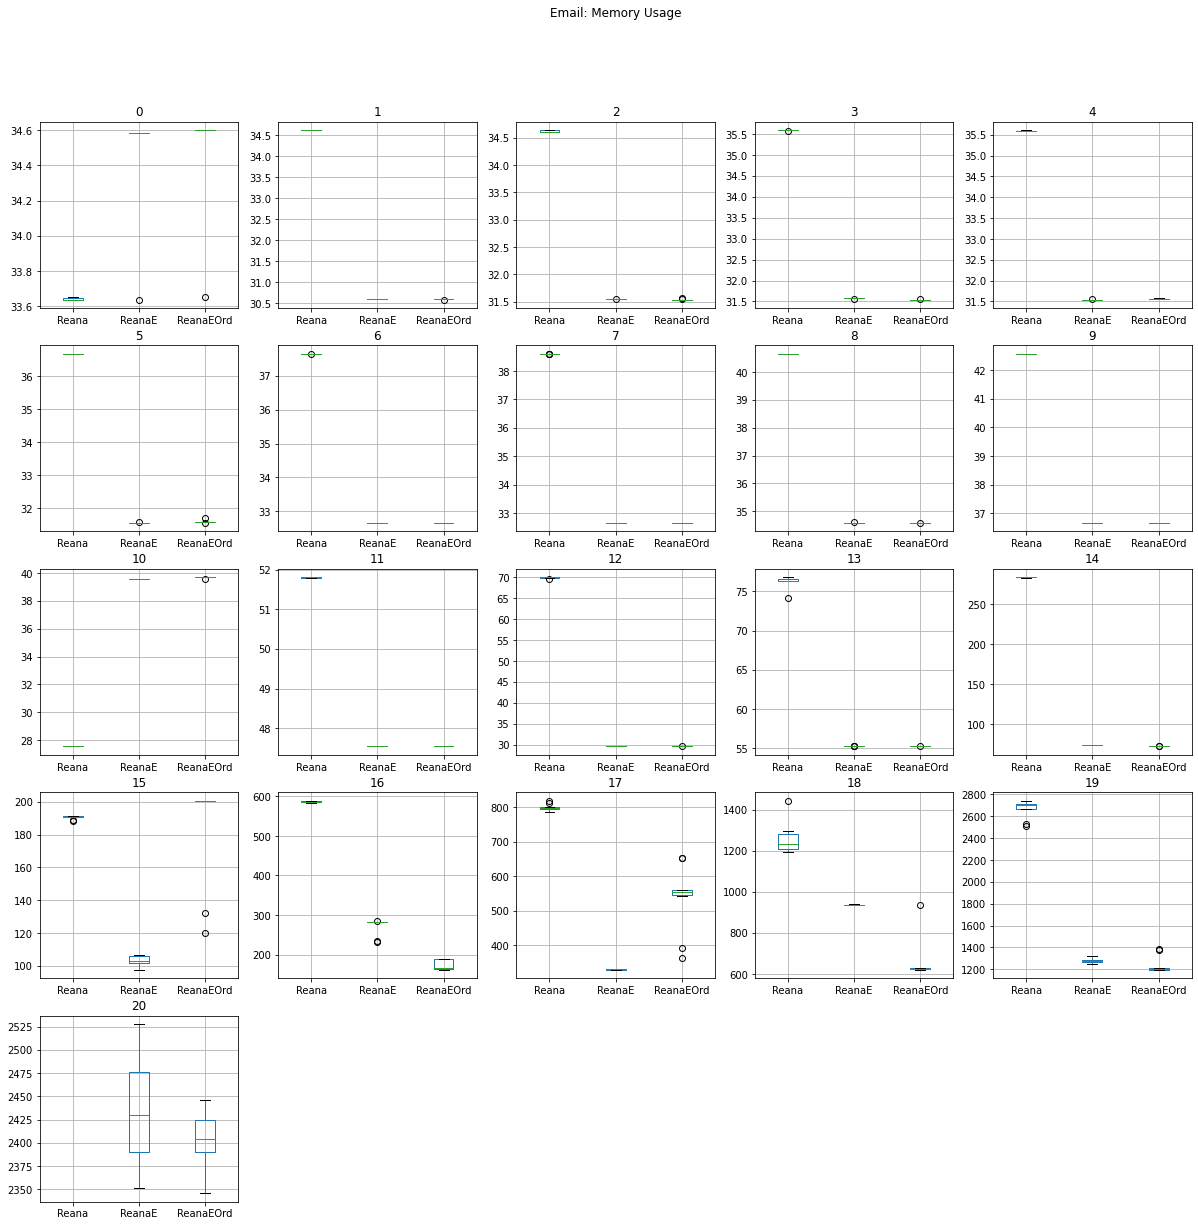

Average memory usage (MB) (statistically smallest value in bold)

| Type | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | **33.64** | 34.62 | 34.62 | 35.59 | 35.59 | 36.69 | 37.65 | 38.59 | 40.66 | 42.58 |
| ReanaE | 34.50 | 30.59 | 31.55 | 31.58 | **31.55** | **31.55** | 32.66 | 32.66 | **34.58** | 36.66 |
| ReanaEOrd | 34.51 | 30.59 | **31.54** | **31.55** | 31.57 | 31.59 | 32.66 | 32.66 | 34.58 | 36.66 |
| --- | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 |
| Reana | **27.56** | 51.80 | 69.88 | 76.21 | 283.83 | 190.64 | 586.04 | 799.88 | 1255.33 | 2671.88 |
| ReanaE | 39.54 | 47.54 | 29.62 | **55.26** | 74.33 | **103.25** | 273.62 | **329.31** | 936.61 | 1276.06 |
| ReanaEOrd | 39.68 | 47.54 | **29.62** | 55.31 | **72.33** | 187.16 | **173.39** | 539.05 | **653.15** | **1232.79** |
| --- | 20 | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Reana | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | 2435.88 | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaEOrd | 2402.97 | -- | -- | -- | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


/Users/breno/Library/Python/3.8/lib/python/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
<ipython-input-2-f2f29a278346>:11: RuntimeWarning: divide by zero encountered in double_scalars
  cohens_d = (np.mean(s1) - np.mean(s2)) / s


Model  Reana Runtime (s)  ReanaE Runtime (s)       H0 Effect Size  \
0    Email 0           0.456364            0.527818  Confirm      Medium   
1    Email 1           0.400273            0.378455  Confirm       Large   
2    Email 2           0.528182            0.379091   Reject       Large   
3    Email 3           0.471545            0.364091   Reject       Large   
4    Email 4           0.426273            0.383364   Reject       Large   
5    Email 5           0.462091            0.373909   Reject       Large   
6    Email 6           0.443727            0.384727   Reject       Large   
7    Email 7           0.466455            0.419545   Reject       Large   
8    Email 8           0.483273            0.436636   Reject       Large   
9    Email 9           0.547727            0.463364   Reject       Large   
10  Email 10           0.942000            0.533182   Reject       Large   
11  Email 11           1.347364            0.682727   Reject       Large   
12  Email 12           2.345909            1.004636   Reject       Large   
13  Email 13           4.488909            1.701364   Reject       Large   
14  Email 14           8.691364            3.171364   Reject       Large   
15  Email 15          17.441818            6.412364   Reject       Large   
16  Email 16          34.967727           12.792364   Reject       Large   
17  Email 17          70.783455           26.460818   Reject       Large   
18  Email 18         145.798909           54.063273   Reject       Large   
19  Email 19         301.254636          111.613364   Reject       Large   

    Reana Memory Usage (MB)  ReanaE Memory Usage (MB)      H0 Effect Size  
0                 33.643083                 34.497555  Reject       Large  
1                 34.622246                 30.594774  Reject       Large  
2                 34.620892                 31.552866  Reject       Large  
3                 35.589509                 31.581390  Reject       Large  
4                 35.592258                 31.547434  Reject       Large  
5                 36.686592                 31.554632  Reject       Large  
6                 37.645950                 32.657333  Reject       Large  
7                 38.586983                 32.657333  Reject       Large  
8                 40.657333                 34.580487  Reject       Large  
9                 42.577469                 36.657333  Reject       Small  
10                27.556937                 39.537537  Reject       Large  
11                51.804528                 47.537537  Reject       Large  
12                69.875493                 29.617339  Reject       Large  
13                76.212803                 55.262138  Reject       Large  
14               283.831498                 74.333149  Reject       Large  
15               190.638771                103.249867  Reject       Large  
16               586.035067                273.620994  Reject       Large  
17               799.878374                329.314840  Reject       Large  
18              1255.332386                936.606357  Reject       Large  
19              2671.878551               1276.060902  Reject       Large

In [31]:
plot_spl('Email')

# IC

## Running Time

/Users/breno/Library/Python/3.8/lib/python/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


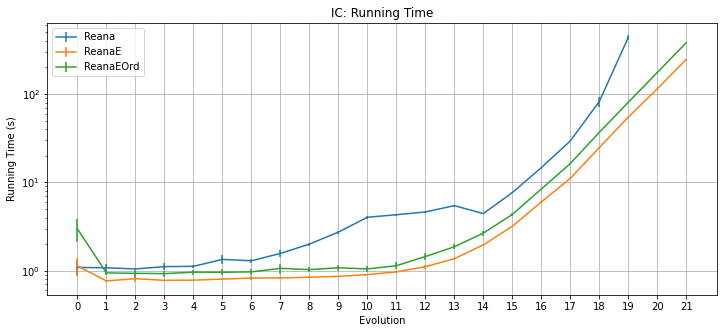

/Users/breno/Library/Python/3.8/lib/python/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/breno/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


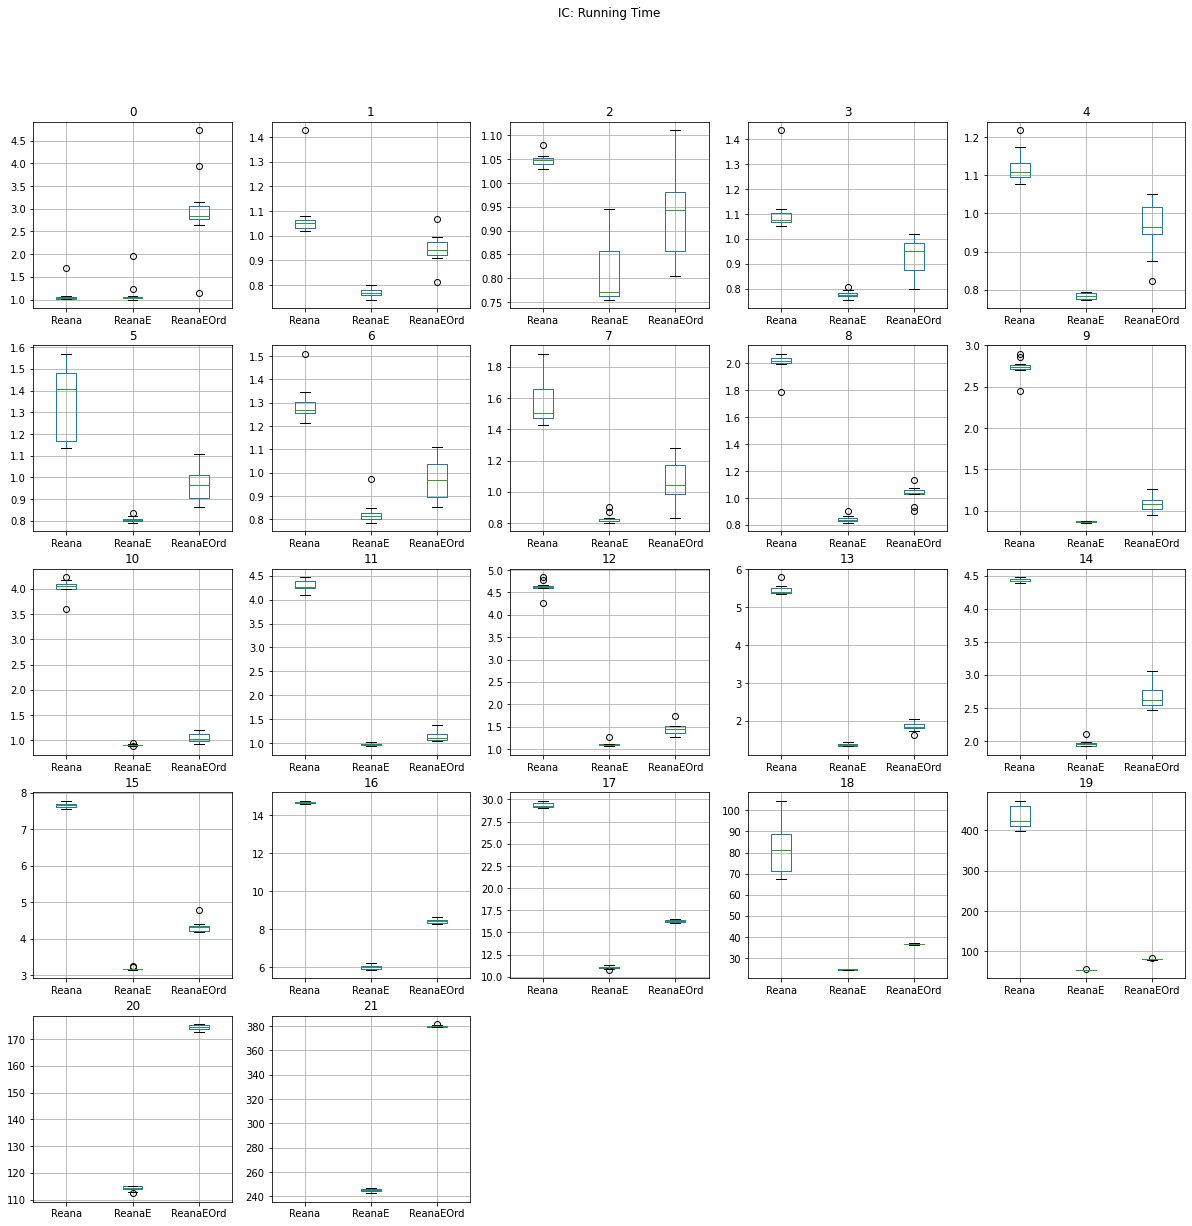

Average running time (s) (statistically smallest value in bold)

| Type | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 1.09 | 1.08 | 1.05 | 1.11 | 1.12 | 1.34 | 1.30 | 1.57 | 2.00 | 2.73 |
| ReanaE | 1.13 | **0.77** | **0.81** | **0.78** | **0.78** | **0.80** | **0.83** | **0.83** | **0.84** | **0.86** |
| ReanaEOrd | 2.97 | 0.95 | 0.94 | 0.93 | 0.96 | 0.96 | 0.97 | 1.07 | 1.03 | 1.08 |
| --- | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 |
| Reana | 4.03 | 4.30 | 4.62 | 5.45 | 4.44 | 7.65 | 14.67 | 29.37 | 82.03 | 434.12 |
| ReanaE | **0.90** | **0.97** | **1.11** | **1.37** | **1.96** | **3.19** | **5.99** | **11.08** | **24.66** | **54.69** |
| ReanaEOrd | 1.05 | 1.14 | 1.45 | 1.87 | 2.66 | 4.33 | 8.40 | 16.32 | 36.71 | 80.48 |
| --- | 20 | 21 | --- | --- | --- | --- | --- | --- | --- | --- |
| Reana | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | **114.18** | **245.04** | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaEOrd | 174.50 | 379.95 | -- | -- | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


## Memory Usage

/Users/breno/Library/Python/3.8/lib/python/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/breno/Library/Python/3.8/lib/python/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


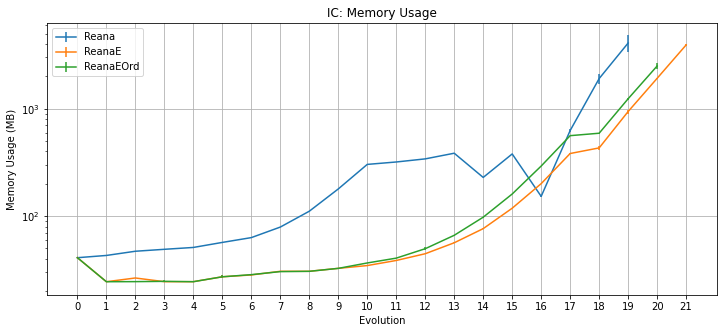

/Users/breno/Library/Python/3.8/lib/python/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/breno/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


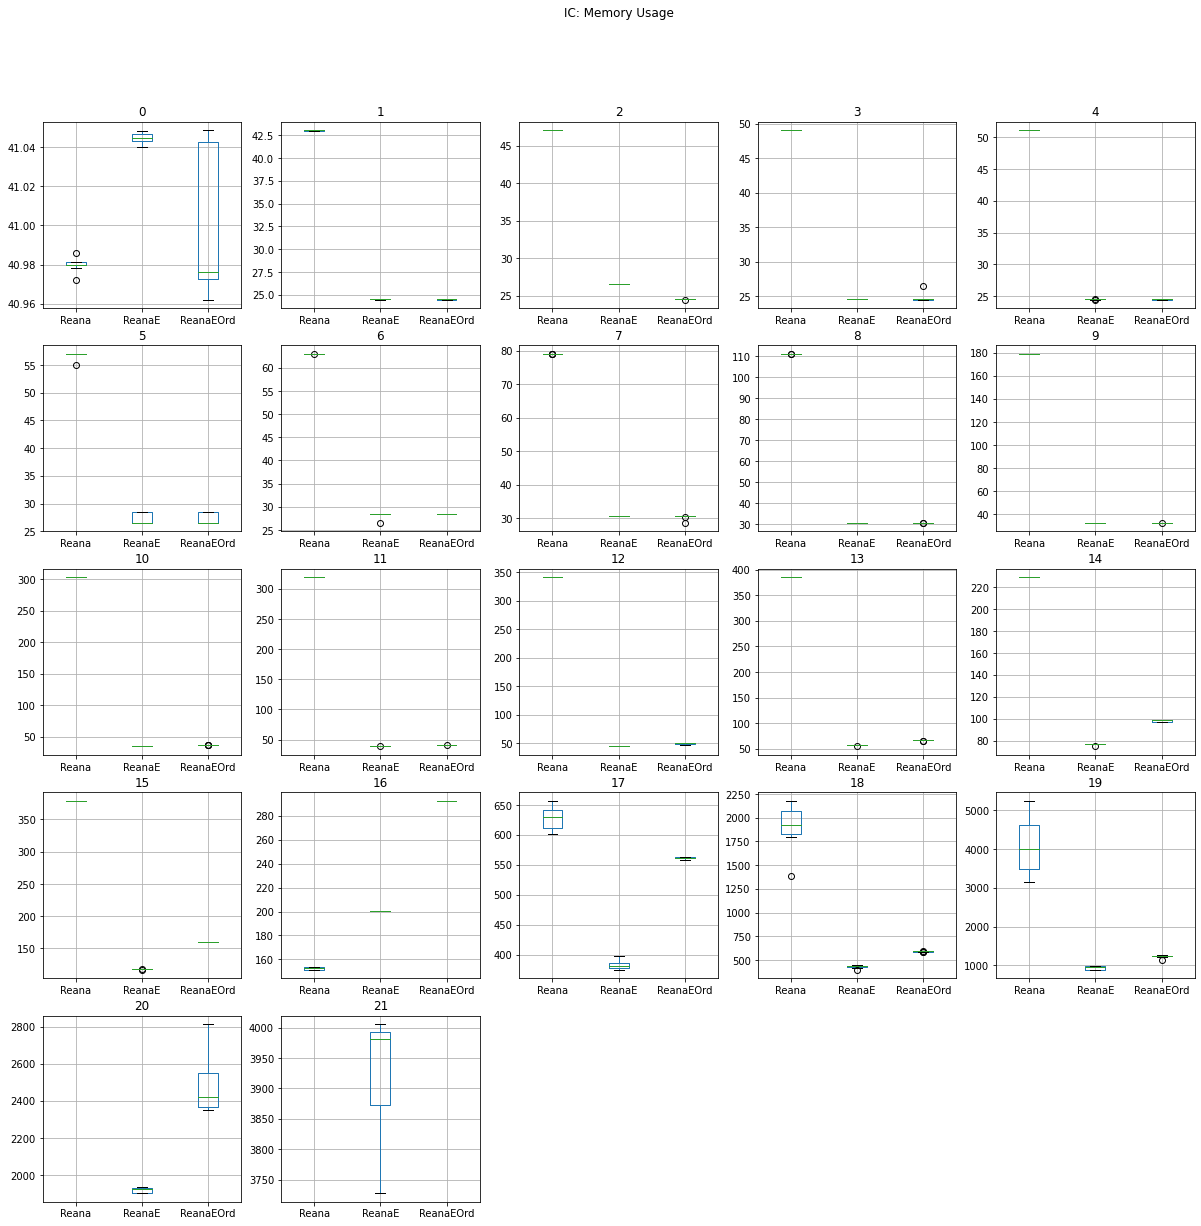

Average memory usage (MB) (statistically smallest value in bold)

| Type | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 40.98 | 43.01 | 47.07 | 49.07 | 51.06 | 56.88 | 63.05 | 79.05 | 111.05 | 179.04 |
| ReanaE | 41.04 | 24.49 | 26.53 | **24.51** | 24.51 | 27.22 | 28.31 | 30.62 | 30.62 | 32.62 |
| ReanaEOrd | 41.00 | 24.49 | **24.53** | 24.68 | 24.50 | 27.21 | 28.50 | 30.42 | **30.60** | 32.61 |
| --- | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 |
| Reana | 303.09 | 319.18 | 341.18 | 385.17 | 229.20 | 379.19 | **152.72** | 626.79 | 1909.54 | 4092.06 |
| ReanaE | **34.62** | **38.62** | **44.62** | **56.44** | **76.44** | **118.44** | 200.62 | **382.81** | **431.67** | **941.86** |
| ReanaEOrd | 36.61 | 40.61 | 49.71 | 66.26 | 97.70 | 160.62 | 292.62 | 561.35 | 591.37 | 1238.97 |
| --- | 20 | 21 | --- | --- | --- | --- | --- | --- | --- | --- |
| Reana | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | **1919.33** | 3924.79 | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaEOrd | 2500.06 | -- | -- | -- | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


/Users/breno/Library/Python/3.8/lib/python/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Model  Reana Runtime (s)  ReanaE Runtime (s)       H0 Effect Size  \
0    IC 0           1.092273            1.134727  Confirm       Small   
1    IC 1           1.079818            0.767636   Reject       Large   
2    IC 2           1.048091            0.814000   Reject       Large   
3    IC 3           1.113636            0.778727   Reject       Large   
4    IC 4           1.122636            0.783364   Reject       Large   
5    IC 5           1.344727            0.804727   Reject       Large   
6    IC 6           1.296455            0.827636   Reject       Large   
7    IC 7           1.571091            0.830000   Reject       Large   
8    IC 8           2.001727            0.844091   Reject       Large   
9    IC 9           2.732000            0.863273   Reject       Large   
10  IC 10           4.030455            0.904273   Reject       Large   
11  IC 11           4.303545            0.970909   Reject       Large   
12  IC 12           4.620727            1.111364   Reject       Large   
13  IC 13           5.454000            1.368727   Reject       Large   
14  IC 14           4.436091            1.959182   Reject       Large   
15  IC 15           7.650182            3.185545   Reject       Large   
16  IC 16          14.671273            5.992727   Reject       Large   
17  IC 17          29.371182           11.083909   Reject       Large   
18  IC 18          82.025545           24.658182   Reject       Large   
19  IC 19         434.116273           54.691636   Reject       Large   

    Reana Memory Usage (MB)  ReanaE Memory Usage (MB)      H0 Effect Size  
0                 40.979897                 41.044545  Reject       Large  
1                 43.010351                 24.489949  Reject       Large  
2                 47.071270                 26.528359  Reject       Large  
3                 49.069439                 24.509196  Reject       Large  
4                 51.063035                 24.505886  Reject       Large  
5                 56.877144                 27.222581  Reject       Large  
6                 63.052976                 28.312168  Reject       Large  
7                 79.045818                 30.617693  Reject       Large  
8                111.045076                 30.617167  Reject       Large  
9                179.039438                 32.620149  Reject       Large  
10               303.085037                 34.620990  Reject       Large  
11               319.183080                 38.620997  Reject       Large  
12               341.178696                 44.623322  Reject       Large  
13               385.174397                 56.442795  Reject       Large  
14               229.198105                 76.443130  Reject       Large  
15               379.191506                118.439991  Reject       Large  
16               152.718928                200.624187  Reject       Large  
17               626.786521                382.808149  Reject       Large  
18              1909.540328                431.671753  Reject       Large  
19              4092.059837                941.862260  Reject       Large

In [32]:
plot_spl('IC')

# Lift

## Running Time

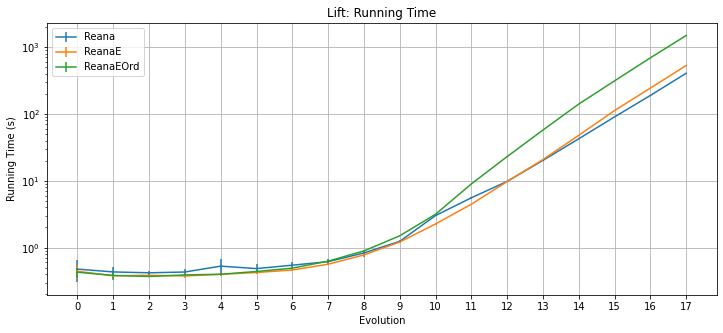

/Users/breno/Library/Python/3.8/lib/python/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/breno/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


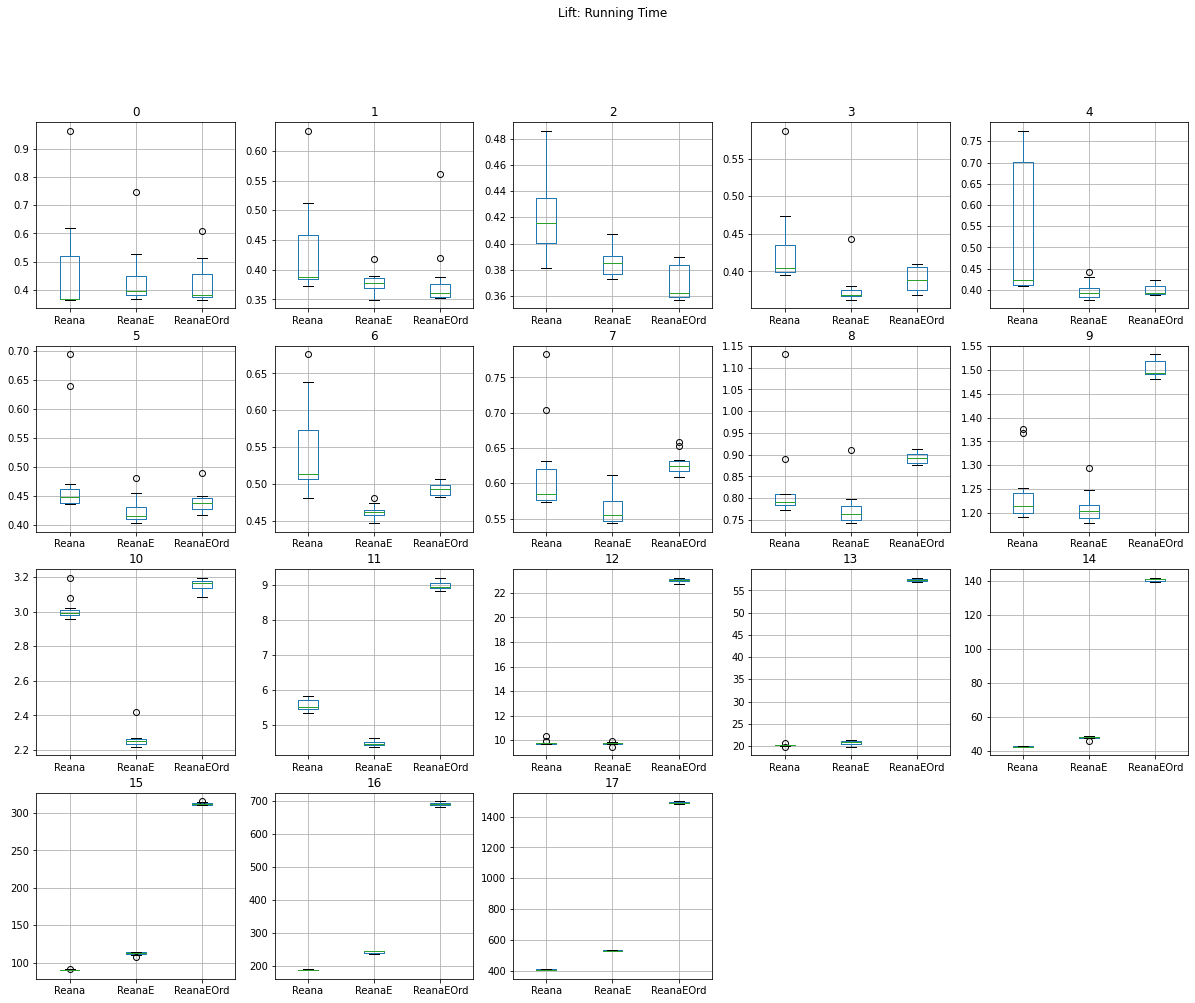

Average running time (s) (statistically smallest value in bold)

| Type | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 0.48 | 0.43 | 0.42 | 0.43 | 0.53 | 0.49 | 0.55 | 0.62 | 0.83 | 1.24 |
| ReanaE | 0.44 | 0.38 | 0.39 | **0.38** | 0.40 | 0.42 | **0.46** | **0.56** | **0.78** | 1.21 |
| ReanaEOrd | 0.43 | 0.38 | **0.37** | 0.39 | 0.40 | 0.44 | 0.49 | 0.63 | 0.89 | 1.50 |
| --- | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | --- | --- |
| Reana | 3.02 | 5.56 | 9.80 | **20.18** | **42.52** | **90.31** | **189.06** | **406.35** | -- | -- |
| ReanaE | **2.26** | **4.46** | 9.74 | 20.76 | 47.83 | 112.42 | 243.52 | 530.43 | -- | -- |
| ReanaEOrd | 3.16 | 8.98 | 23.01 | 57.40 | 140.57 | 312.35 | 691.13 | 1490.64 | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


## Memory Usage

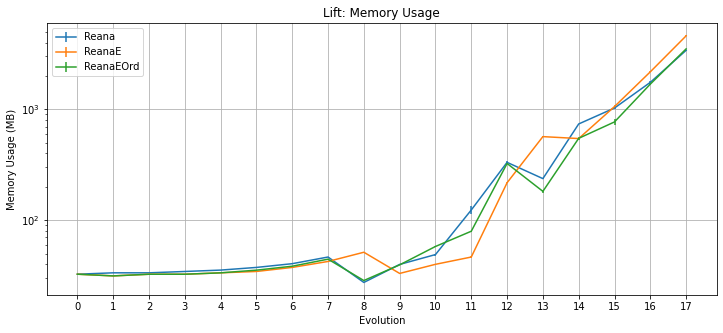

/Users/breno/Library/Python/3.8/lib/python/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
<ipython-input-2-f2f29a278346>:11: RuntimeWarning: divide by zero encountered in double_scalars
  cohens_d = (np.mean(s1) - np.mean(s2)) / s
<ipython-input-2-f2f29a278346>:11: RuntimeWarning: invalid value encountered in double_scalars
  cohens_d = (np.mean(s1) - np.mean(s2)) / s
/Users/breno/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


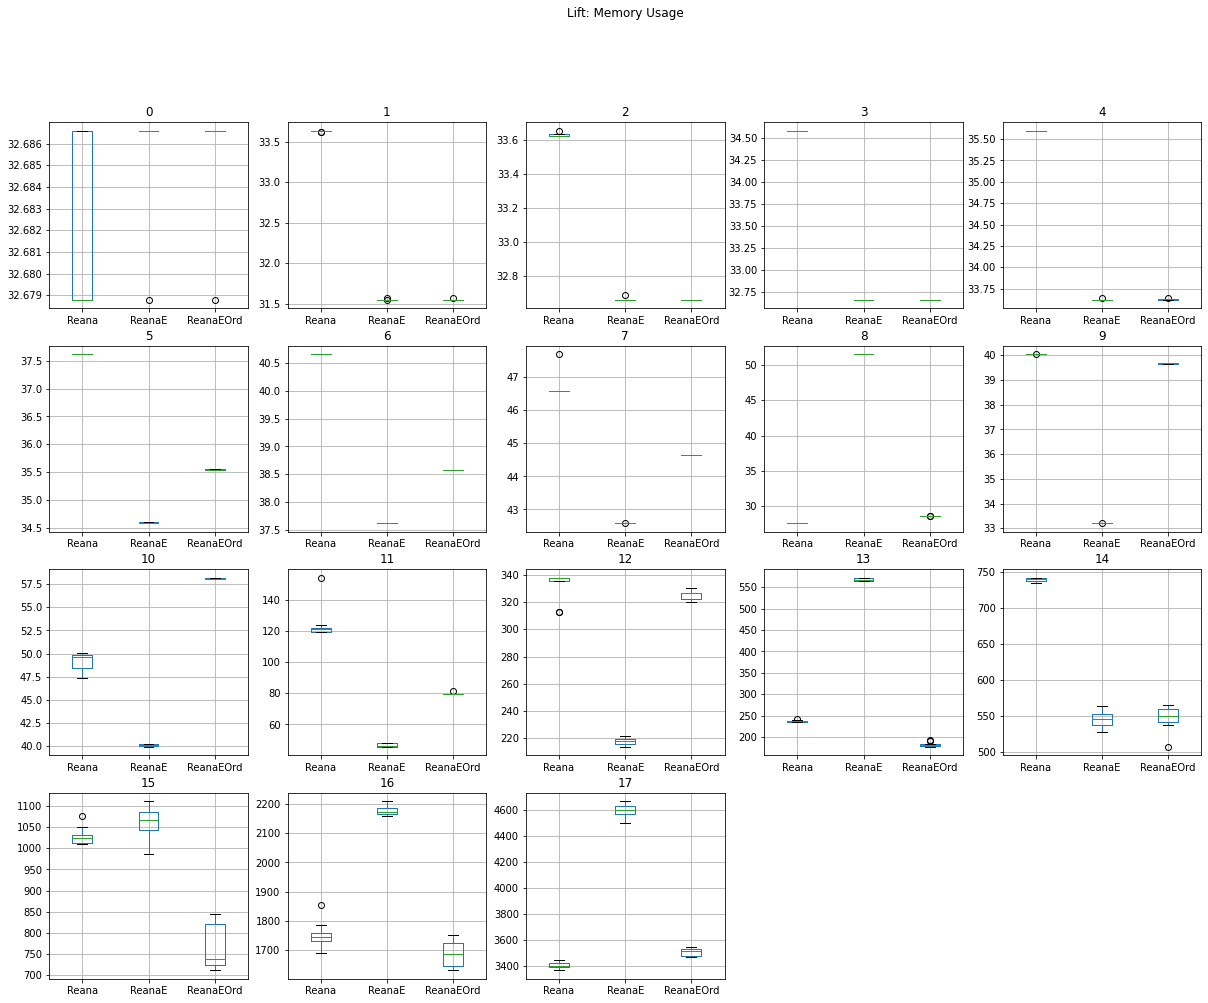

Average memory usage (MB) (statistically smallest value in bold)

| Type | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | **32.68** | 33.64 | 33.63 | 34.59 | 35.59 | 37.62 | 40.66 | 46.68 | **27.54** | 40.03 |
| ReanaE | 32.69 | 31.55 | 32.66 | 32.66 | **33.62** | **34.59** | **37.62** | **42.58** | 51.54 | **33.21** |
| ReanaEOrd | 32.69 | 31.55 | 32.66 | 32.66 | 33.62 | 35.55 | 38.58 | 44.66 | 28.66 | 39.67 |
| --- | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | --- | --- |
| Reana | 49.12 | 123.89 | 332.89 | 237.52 | 738.34 | 1027.70 | 1750.24 | **3402.24** | -- | -- |
| ReanaE | **40.12** | **46.67** | **218.00** | 567.72 | 545.41 | 1059.15 | 2177.51 | 4594.06 | -- | -- |
| ReanaEOrd | 58.10 | 79.71 | 325.14 | **182.33** | 547.89 | **770.06** | **1687.51** | 3505.33 | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


/Users/breno/Library/Python/3.8/lib/python/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
<ipython-input-2-f2f29a278346>:11: RuntimeWarning: divide by zero encountered in double_scalars
  cohens_d = (np.mean(s1) - np.mean(s2)) / s


Model  Reana Runtime (s)  ReanaE Runtime (s)       H0 Effect Size  \
0    Lift 0           0.476727            0.442455  Confirm       Small   
1    Lift 1           0.432636            0.378000  Confirm       Large   
2    Lift 2           0.420091            0.385273   Reject       Large   
3    Lift 3           0.431455            0.376545   Reject       Large   
4    Lift 4           0.528455            0.398636  Confirm       Large   
5    Lift 5           0.485455            0.424182   Reject       Large   
6    Lift 6           0.545818            0.462455   Reject       Large   
7    Lift 7           0.616364            0.564182   Reject       Large   
8    Lift 8           0.832182            0.777909   Reject       Large   
9    Lift 9           1.240727            1.212000  Confirm      Medium   
10  Lift 10           3.015182            2.261545   Reject       Large   
11  Lift 11           5.563818            4.456364   Reject       Large   
12  Lift 12           9.797091            9.743000  Confirm      Medium   
13  Lift 13          20.182273           20.761636   Reject       Large   
14  Lift 14          42.515909           47.833182   Reject       Large   
15  Lift 15          90.305182          112.421636   Reject       Large   
16  Lift 16         189.063818          243.523727   Reject       Large   
17  Lift 17         406.352636          530.428000   Reject       Large   

    Reana Memory Usage (MB)  ReanaE Memory Usage (MB)       H0 Effect Size  
0                 32.681621                 32.685882   Reject       Large  
1                 33.636013                 31.546253   Reject       Large  
2                 33.630912                 32.659993   Reject       Large  
3                 34.585216                 32.657333   Reject       Large  
4                 35.592257                 33.619337   Reject       Large  
5                 37.617401                 34.588459   Reject       Large  
6                 40.657333                 37.617401   Reject       Small  
7                 46.679091                 42.578884   Reject       Large  
8                 27.544223                 51.537537   Reject       Large  
9                 40.033294                 33.205025   Reject       Large  
10                49.117543                 40.119849   Reject       Large  
11               123.893461                 46.668990   Reject       Large  
12               332.885524                218.004483   Reject       Large  
13               237.524688                567.717020   Reject       Large  
14               738.335938                545.408425   Reject       Large  
15              1027.697089               1059.151101  Confirm       Large  
16              1750.241122               2177.514560   Reject       Large  
17              3402.242188               4594.060369   Reject       Large

In [33]:
plot_spl('Lift')

# MP

## Running Time

/Users/breno/Library/Python/3.8/lib/python/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


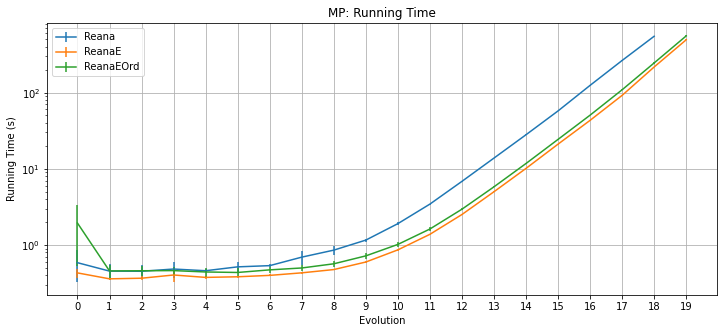

/Users/breno/Library/Python/3.8/lib/python/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/breno/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


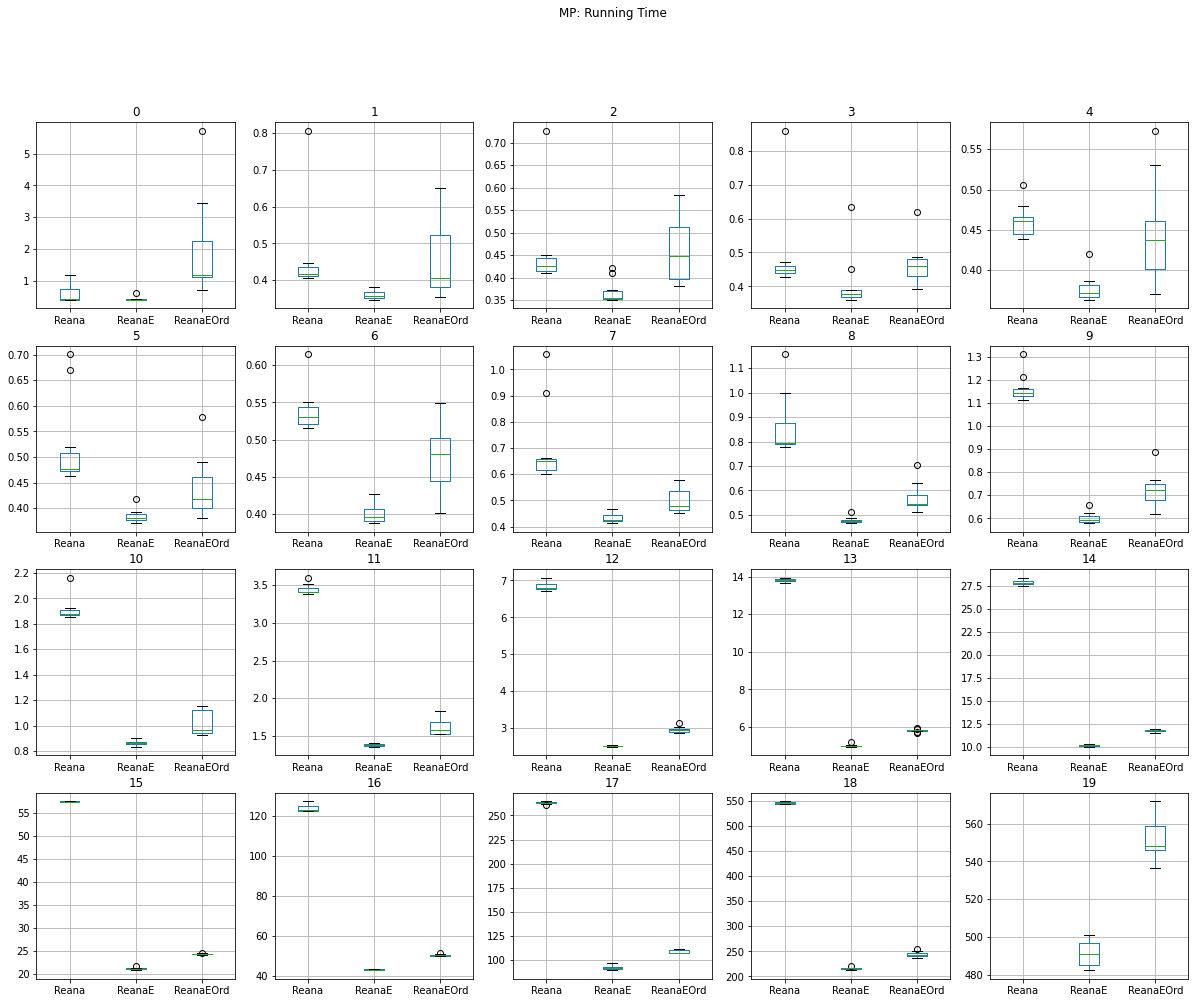

Average running time (s) (statistically smallest value in bold)

| Type | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 0.59 | 0.46 | 0.45 | 0.49 | 0.46 | 0.52 | 0.54 | 0.69 | 0.86 | 1.16 |
| ReanaE | 0.43 | **0.36** | **0.37** | **0.41** | **0.38** | **0.38** | **0.40** | **0.43** | **0.48** | **0.60** |
| ReanaEOrd | 1.94 | 0.46 | 0.46 | 0.46 | 0.44 | 0.44 | 0.47 | 0.50 | 0.57 | 0.72 |
| --- | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 |
| Reana | 1.91 | 3.44 | 6.84 | 13.82 | 27.95 | 57.37 | 124.09 | 263.03 | 546.32 | -- |
| ReanaE | **0.87** | **1.38** | **2.52** | **5.00** | **10.12** | **21.04** | **43.16** | **91.76** | **216.05** | **490.91** |
| ReanaEOrd | 1.02 | 1.62 | 2.95 | 5.80 | 11.74 | 24.30 | 50.48 | 108.61 | 244.20 | 551.96 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Reana | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaEOrd | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


## Memory Usage

/Users/breno/Library/Python/3.8/lib/python/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


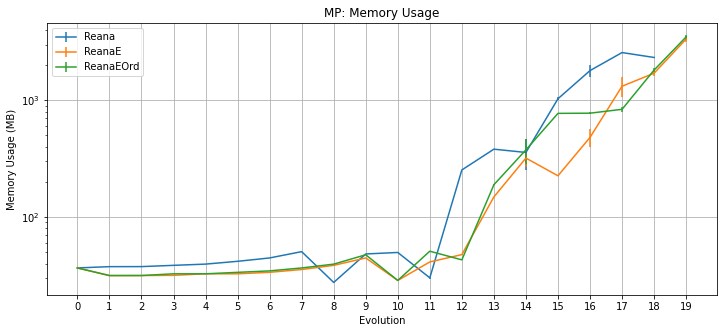

/Users/breno/Library/Python/3.8/lib/python/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
<ipython-input-2-f2f29a278346>:11: RuntimeWarning: divide by zero encountered in double_scalars
  cohens_d = (np.mean(s1) - np.mean(s2)) / s
<ipython-input-2-f2f29a278346>:11: RuntimeWarning: invalid value encountered in double_scalars
  cohens_d = (np.mean(s1) - np.mean(s2)) / s
/Users/breno/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


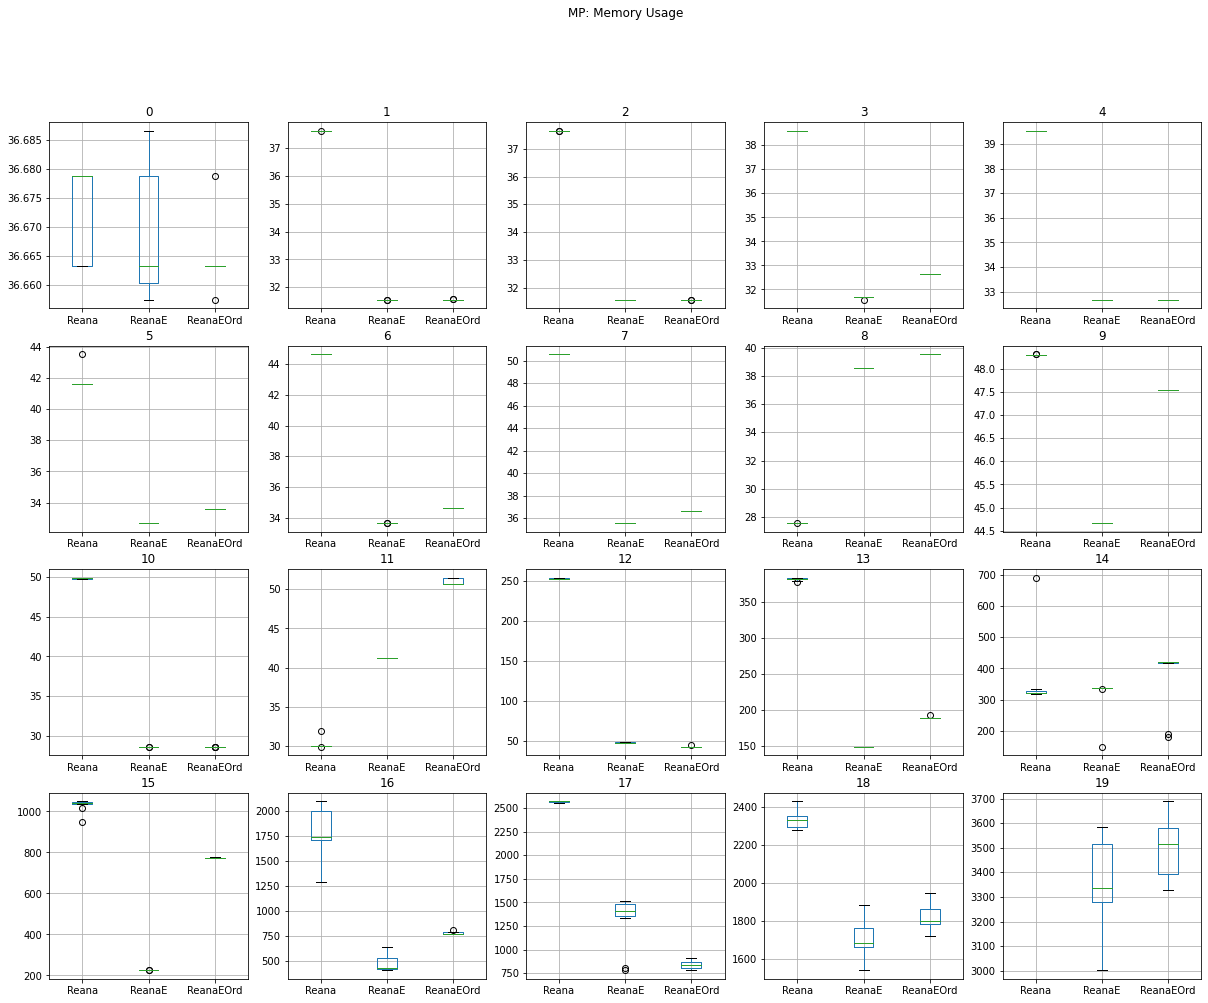

Average memory usage (MB) (statistically smallest value in bold)

| Type | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 36.67 | 37.62 | 37.64 | 38.60 | 39.55 | 41.79 | 44.66 | 50.58 | **27.54** | 48.30 |
| ReanaE | 36.67 | **31.55** | 31.57 | **31.68** | 32.66 | **32.66** | **33.64** | **35.55** | 38.58 | **44.66** |
| ReanaEOrd | 36.66 | 31.56 | 31.57 | 32.66 | 32.66 | 33.62 | 34.60 | 36.66 | 39.54 | 47.54 |
| --- | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 |
| Reana | 49.76 | **30.16** | 253.35 | 381.74 | 357.81 | 1031.98 | 1798.60 | 2566.79 | 2330.42 | -- |
| ReanaE | 28.66 | 41.26 | 47.70 | **148.86** | **320.29** | **225.84** | **481.38** | 1320.69 | 1708.61 | 3348.60 |
| ReanaEOrd | **28.66** | 51.03 | **43.00** | 189.27 | 376.60 | 773.60 | 776.42 | **838.06** | 1816.79 | 3494.61 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Reana | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaEOrd | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


/Users/breno/Library/Python/3.8/lib/python/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
<ipython-input-2-f2f29a278346>:11: RuntimeWarning: divide by zero encountered in double_scalars
  cohens_d = (np.mean(s1) - np.mean(s2)) / s


Model  Reana Runtime (s)  ReanaE Runtime (s)       H0 Effect Size  \
0    MP 0           0.587727            0.431909  Confirm       Large   
1    MP 1           0.455909            0.361000   Reject       Large   
2    MP 2           0.453545            0.367818   Reject       Large   
3    MP 3           0.485273            0.405364   Reject       Large   
4    MP 4           0.461182            0.377091   Reject       Large   
5    MP 5           0.518364            0.384182   Reject       Large   
6    MP 6           0.537636            0.400727   Reject       Large   
7    MP 7           0.694818            0.432636   Reject       Large   
8    MP 8           0.858545            0.477545   Reject       Large   
9    MP 9           1.162364            0.599636   Reject       Large   
10  MP 10           1.909000            0.865091   Reject       Large   
11  MP 11           3.444364            1.383545   Reject       Large   
12  MP 12           6.841909            2.515545   Reject       Large   
13  MP 13          13.818818            5.002727   Reject       Large   
14  MP 14          27.947182           10.116273   Reject       Large   
15  MP 15          57.365636           21.044455   Reject       Large   
16  MP 16         124.088455           43.156091   Reject       Large   
17  MP 17         263.033727           91.761091   Reject       Large   
18  MP 18         546.317091          216.049364   Reject       Large   

    Reana Memory Usage (MB)  ReanaE Memory Usage (MB)       H0 Effect Size  
0                 36.672424                 36.669414  Confirm      Medium  
1                 37.617392                 31.548540   Reject       Large  
2                 37.644140                 31.568637   Reject       Large  
3                 38.596755                 31.683085   Reject       Large  
4                 39.545280                 32.657333   Reject       Small  
5                 41.791959                 32.657333   Reject       Large  
6                 44.657333                 33.638141   Reject       Large  
7                 50.577469                 35.547616   Reject       Large  
8                 27.544554                 38.577469   Reject       Large  
9                 48.301353                 44.657333   Reject       Large  
10                49.762434                 28.660858   Reject       Large  
11                30.164956                 41.263890   Reject       Large  
12               253.351056                 47.702565   Reject       Large  
13               381.743741                148.861377   Reject       Large  
14               357.814675                320.290345   Reject      Medium  
15              1031.981621                225.836343   Reject       Large  
16              1798.598919                481.376154   Reject       Large  
17              2566.786932               1320.691011   Reject       Large  
18              2330.423828               1708.605646   Reject       Large

In [34]:
plot_spl('MP')

# TW

## Running Time

/Users/breno/Library/Python/3.8/lib/python/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/breno/Library/Python/3.8/lib/python/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


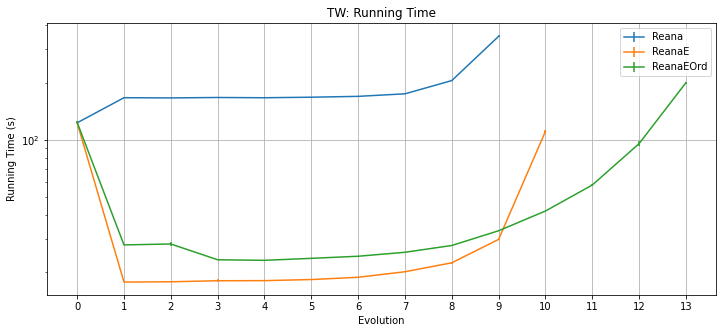

/Users/breno/Library/Python/3.8/lib/python/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/breno/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


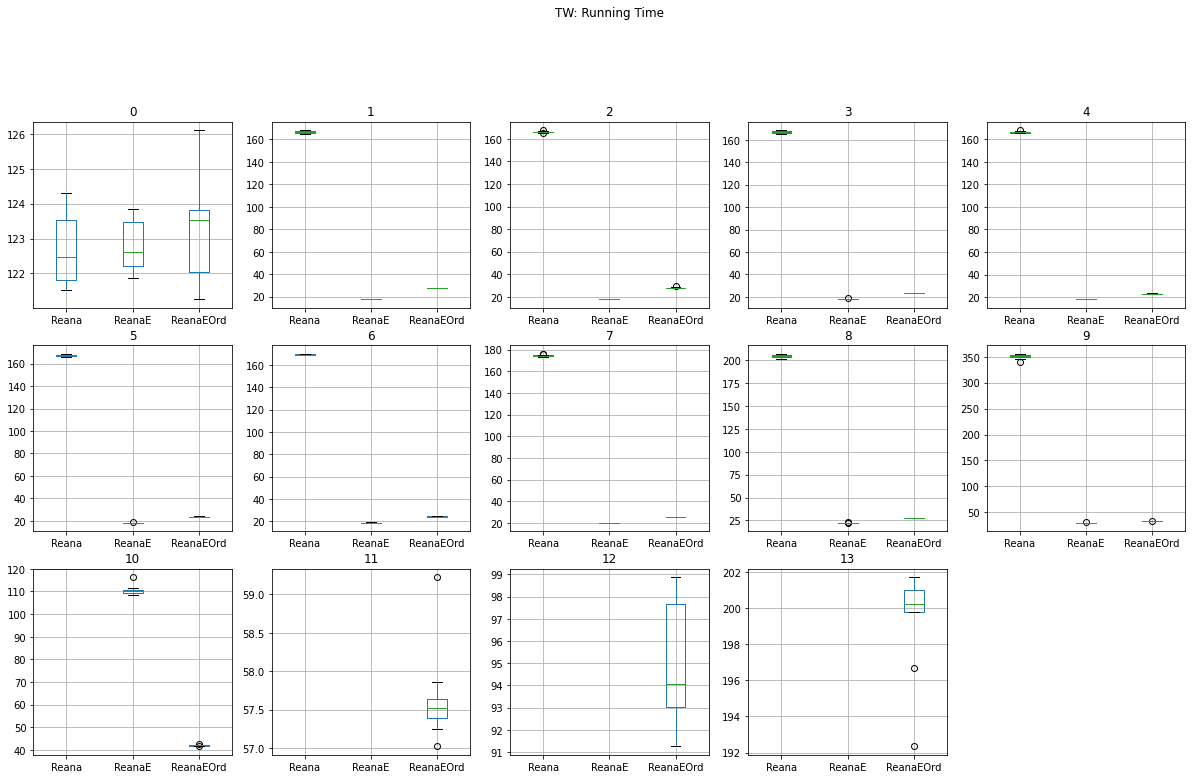

Average running time (s) (statistically smallest value in bold)

| Type | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 122.71 | 166.44 | 166.03 | 166.88 | 166.38 | 167.47 | 169.20 | 174.49 | 204.92 | 350.56 |
| ReanaE | 122.85 | **17.75** | **17.81** | **18.03** | **18.06** | **18.30** | **18.81** | **20.11** | **22.42** | **29.78** |
| ReanaEOrd | 123.34 | 27.87 | 28.18 | 23.26 | 23.11 | 23.67 | 24.28 | 25.48 | 27.67 | 33.08 |
| --- | 10 | 11 | 12 | 13 | --- | --- | --- | --- | --- | --- |
| Reana | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | 110.54 | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaEOrd | **42.04** | 57.64 | 95.25 | 199.53 | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


## Memory Usage

/Users/breno/Library/Python/3.8/lib/python/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/breno/Library/Python/3.8/lib/python/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


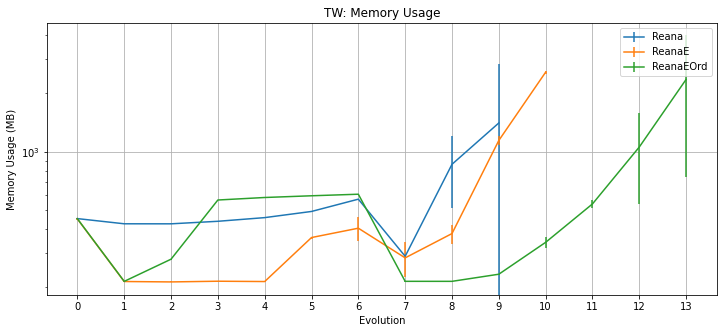

/Users/breno/Library/Python/3.8/lib/python/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/breno/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/boxplot.py:385: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  ax = boxplot(


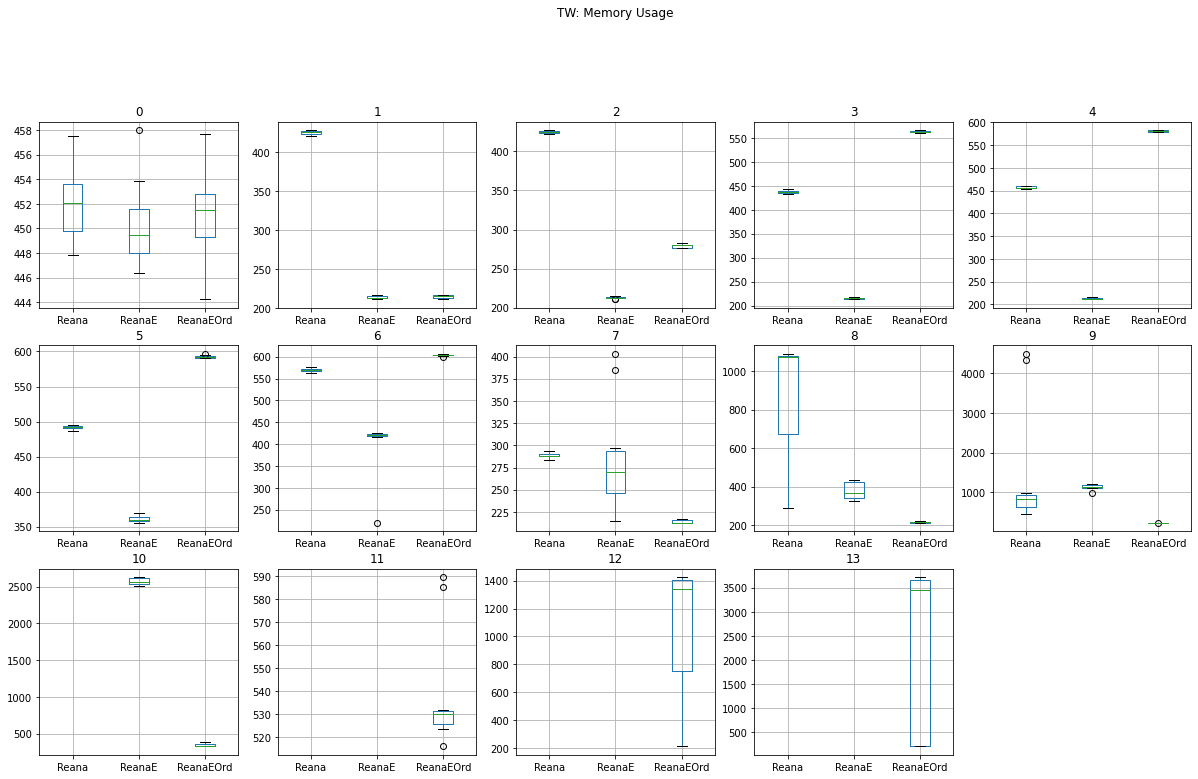

Average memory usage (MB) (statistically smallest value in bold)

| Type | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
|---|---|---|---|---|---|---|---|---|---|---|
| Reana | 451.80 | 424.79 | 424.63 | 437.61 | 457.11 | 491.86 | 569.16 | 288.71 | 861.45 | 1407.51 |
| ReanaE | 450.13 | 213.93 | **212.88** | **214.68** | **213.86** | **360.78** | **403.10** | 283.32 | 378.21 | 1143.57 |
| ReanaEOrd | 451.08 | 214.27 | 278.89 | 563.55 | 580.60 | 592.57 | 603.69 | **214.40** | **214.36** | **233.30** |
| --- | 10 | 11 | 12 | 13 | --- | --- | --- | --- | --- | --- |
| Reana | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaE | 2574.06 | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| ReanaEOrd | **340.79** | 537.84 | 1057.77 | 2362.22 | -- | -- | -- | -- | -- | -- |
|---|---|---|---|---|---|---|---|---|---|---|


/Users/breno/Library/Python/3.8/lib/python/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Model  Reana Runtime (s)  ReanaE Runtime (s)       H0 Effect Size  \
0  TW 0         122.711455          122.848000  Confirm       Small   
1  TW 1         166.439545           17.748182   Reject       Large   
2  TW 2         166.029636           17.805727   Reject       Large   
3  TW 3         166.883182           18.033091   Reject       Large   
4  TW 4         166.379727           18.056364   Reject       Large   
5  TW 5         167.472818           18.297909   Reject       Large   
6  TW 6         169.198182           18.807909   Reject       Large   
7  TW 7         174.494727           20.113182   Reject       Large   
8  TW 8         204.917818           22.422818   Reject       Large   
9  TW 9         350.560182           29.780636   Reject       Large   

   Reana Memory Usage (MB)  ReanaE Memory Usage (MB)       H0 Effect Size  
0               451.799520                450.129661  Confirm      Medium  
1               424.793460                213.928629   Reject       Large  
2               424.628141                212.880671   Reject       Large  
3               437.608426                214.684230   Reject       Large  
4               457.110381                213.862466   Reject       Large  
5               491.855645                360.776878   Reject       Large  
6               569.162953                403.100111   Reject       Large  
7               288.710072                283.324740  Confirm       Small  
8               861.451923                378.211914   Reject       Large  
9              1407.514560               1143.571136   Reject       Small

In [35]:
plot_spl('TW')